# Explore latent space features
We want to know if our VAE model is capturing our signal

Identify high weight (HW) genes for each latent space feature (node)
Determine if genes in group A and B are found within these highly weighted genes

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


randomState = 123
from numpy.random import seed
seed(randomState)

In [2]:
# Load arguments
analysis_name = "sim_AB_2775_300_v2"
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "VAE_weight_matrix.txt")
A_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetA.txt")
B_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetB.txt")

#HW_file = os.path.join(os.path.dirname(os.getcwd()), "output", analysis_name, "HW_genes.txt")

In [3]:
# Read in data
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

weight = pd.read_table(data_file, header=0, index_col=0).T
weight.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
PA0001,-0.117849,-0.038603,0.025833,-0.017812,-0.038917,-0.025886,0.059616,-0.004224,0.061998,-0.104676,...,0.019363,0.007815,-0.052154,0.025949,0.021723,0.055437,-0.018286,0.016438,0.005548,-0.062284
PA0002,-0.475532,-0.376902,-0.292408,-0.443579,-0.275428,-0.237486,-0.131763,-0.309244,-0.123432,-0.239483,...,-0.337239,-0.167598,-0.673273,-0.215697,0.234006,-0.104485,-0.352983,-0.189724,-0.374923,-0.435261
PA0003,-0.028016,-0.147888,-0.118208,-0.176184,0.085006,-0.136751,-0.007269,-0.030653,-0.057265,-0.159458,...,0.029716,-0.110118,-0.190486,-0.035492,-0.083336,-0.039024,-0.120915,0.122573,-0.090189,-0.163588
PA0004,-0.008260,-0.027175,-0.036942,-0.081368,-0.004079,0.048033,-0.006661,0.012838,0.123765,-0.027641,...,0.028078,0.090266,0.021577,-0.017694,0.023099,-0.028170,0.063105,0.006962,0.101481,-0.073981
PA0005,0.056511,0.146070,0.111143,0.195392,0.008957,0.173715,0.095491,0.130729,-0.015219,0.029992,...,-0.012573,0.007769,-0.009655,0.074925,0.057350,0.033258,0.060091,0.037214,-0.054149,0.050110


In [4]:
# Plot the distribution of gene weights per latent feature
#num_features = weight.shape[1]

#f, axes = plt.subplots(num_features, 1, sharex=True)
#for i, ax in zip(weight.columns, axes.flat):
#    sns.distplot(weight[i] , color="skyblue", rug=False, kde=False, ax=ax)
    
#f.set_size_inches(15, 15)

In [5]:
# Calculate mean per node ("signature" or "feature")
means = weight.mean(axis=0)

# Calculate 2 standard deviations per node ("signature" or "feature")
stds = weight.std(axis=0)
two_stds = 2*stds

In [6]:
# Get high positive and negative weight genes per node ("signature" or "feature") -- HW_df
# Record metadata per latent feature in a table -- HW_metadata_df
# Record distance between gene set weight and 
HW_df = pd.DataFrame()
HW_metadata_df = pd.DataFrame()

num_nodes = len(means)

for i in range(num_nodes):
    node_mean = means.iloc[i]
    node_std = stds.iloc[i] 
    
    pos_threshold = node_mean + two_stds.iloc[i]
    neg_threshold = node_mean - two_stds.iloc[i]
    
    hw_pos_genes = weight[weight[i] > pos_threshold].index
    hw_neg_genes = weight[weight[i] < neg_threshold].index
    
    node = str(i)
    node_name = 'Sig'+node+'pos'
    
    # Add high weight positive genes
    add_pos = pd.DataFrame({node_name: list(hw_pos_genes)})
    HW_df = pd.concat([HW_df, add_pos], axis=1)
    
    # Add metadata for positive node
    add_metadata_pos = pd.DataFrame({node_name: [node_mean, node_std, pos_threshold]})
    HW_metadata_df = pd.concat([HW_metadata_df, add_metadata_pos], axis=1)
    
    # Add high weight negative genes
    node_name = 'Sig'+node+'neg'
    
    add_neg = pd.DataFrame({node_name: list(hw_neg_genes)})
    HW_df = pd.concat([HW_df, add_neg], axis=1)
    
    # Add metadata for negative node
    add_metadata_neg = pd.DataFrame({node_name: [node_mean, node_std, neg_threshold]})
    HW_metadata_df = pd.concat([HW_metadata_df, add_metadata_neg], axis=1)

HW_df = HW_df.T
HW_metadata_df = HW_metadata_df.T

In [7]:
HW_df.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
Sig0pos,PA0117,PA0276,PA0320,PA0716,PA0848,PA1239,PA1240,PA1632,PA1696,PA1701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig0neg,PA0002,PA0019,PA0083,PA0299,PA0310,PA0384,PA0432,PA0454,PA0456,PA0556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig1pos,PA0062,PA0117,PA0184,PA0228,PA0442,PA0465,PA0613,PA0614,PA0615,PA0620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig1neg,PA0002,PA0015,PA0019,PA0053,PA0083,PA0250,PA0260,PA0384,PA0398,PA0432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sig2pos,PA0442,PA0466,PA0498,PA0677,PA0688,PA0940,PA0978,PA0980,PA0985,PA0987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Dataframe with the mean, std, threshold used per feature to determine high weight gene sets
HW_metadata_df.columns = ["mean", "std", "threshold"]
HW_metadata_df.head()

,mean,std,threshold
Sig0pos,0.049819,0.130466,0.310750
Sig0neg,0.049819,0.130466,-0.211112
Sig1pos,0.042705,0.134988,0.312681
Sig1neg,0.042705,0.134988,-0.227272
Sig2pos,0.022017,0.116120,0.254257


In [9]:
# Create a table (feature x gene set A)
# Each cell will contain the distance between the weight and the mean

Weights_pos_neg_df = pd.DataFrame()

for i in range(num_nodes):
    node_mean = means.iloc[i]
    
    node = str(i+1)
    node_name = 'Sig'+node+'pos'
    
    gene_weight = weight[i]
    
    # Add high weight positive genes
    add_pos = pd.DataFrame({node_name: gene_weight})
    Weights_pos_neg_df = pd.concat([Weights_pos_neg_df, add_pos], axis=1)
    
    # Add high weight negative genes
    node_name = 'Sig'+node+'neg'
    
    add_neg = pd.DataFrame({node_name: gene_weight})
    Weights_pos_neg_df = pd.concat([Weights_pos_neg_df, add_neg], axis=1)
    
    
Weights_pos_neg_df = Weights_pos_neg_df.T
Weights_pos_neg_df.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
Sig1pos,-0.117849,-0.475532,-0.028016,-0.008260,0.056511,0.000049,0.121879,-0.042821,-0.058594,-0.004900,...,0.011380,-0.009411,-0.225738,-0.129943,0.022048,0.089639,0.029759,-0.049430,0.006432,-0.076880
Sig1neg,-0.117849,-0.475532,-0.028016,-0.008260,0.056511,0.000049,0.121879,-0.042821,-0.058594,-0.004900,...,0.011380,-0.009411,-0.225738,-0.129943,0.022048,0.089639,0.029759,-0.049430,0.006432,-0.076880
Sig2pos,-0.038603,-0.376902,-0.147888,-0.027175,0.146070,0.042451,0.030219,0.030739,0.110625,0.105733,...,-0.030633,0.007829,-0.031843,-0.038202,0.036953,0.138229,-0.022253,-0.018712,0.006634,0.077839
Sig2neg,-0.038603,-0.376902,-0.147888,-0.027175,0.146070,0.042451,0.030219,0.030739,0.110625,0.105733,...,-0.030633,0.007829,-0.031843,-0.038202,0.036953,0.138229,-0.022253,-0.018712,0.006634,0.077839
Sig3pos,0.025833,-0.292408,-0.118208,-0.036942,0.111143,0.020100,0.149831,-0.005671,0.009560,0.076310,...,-0.013253,-0.087995,-0.047683,-0.118559,-0.049390,0.105825,-0.066080,-0.018374,-0.127281,-0.031827


In [10]:
# Compare the weights for geneset A with threshold
geneSetA_ls = [l[0] for l in geneSetA.values.tolist()]
Weight_A = Weights_pos_neg_df[geneSetA_ls]

Weight_A.head()

,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA1766,PA4217,PA0996,PA3950,PA5115,PA0505,PA0114,PA5150,PA4042,PA2678
Sig1pos,0.113355,0.100247,0.096007,0.076656,0.110575,0.107409,0.098403,0.105107,0.077743,0.110219,...,0.116383,0.098540,0.116400,0.098785,0.104415,0.122268,0.115080,0.097363,0.123035,0.115820
Sig1neg,0.113355,0.100247,0.096007,0.076656,0.110575,0.107409,0.098403,0.105107,0.077743,0.110219,...,0.116383,0.098540,0.116400,0.098785,0.104415,0.122268,0.115080,0.097363,0.123035,0.115820
Sig2pos,-0.015330,-0.028314,-0.033096,-0.028398,-0.024776,-0.036104,-0.024187,-0.062008,-0.010386,-0.006959,...,-0.032418,-0.043319,-0.012980,-0.016076,-0.054778,-0.020810,-0.039916,-0.026502,-0.055231,-0.032503
Sig2neg,-0.015330,-0.028314,-0.033096,-0.028398,-0.024776,-0.036104,-0.024187,-0.062008,-0.010386,-0.006959,...,-0.032418,-0.043319,-0.012980,-0.016076,-0.054778,-0.020810,-0.039916,-0.026502,-0.055231,-0.032503
Sig3pos,-0.229650,-0.249490,-0.215178,-0.208008,-0.219033,-0.199936,-0.189975,-0.223268,-0.199104,-0.213147,...,-0.194955,-0.228450,-0.199388,-0.222071,-0.260503,-0.220613,-0.214862,-0.200054,-0.215501,-0.189678


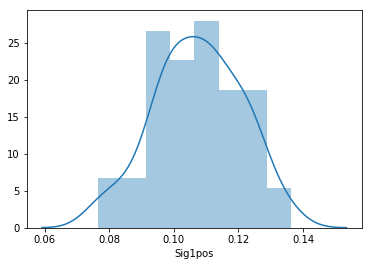

In [11]:
sns.distplot(Weight_A.iloc[0])

In [12]:
# Compare the weights for geneset B with threshold
geneSetB_ls = [l[0] for l in geneSetB.values.tolist()]
Weight_B = Weights_pos_neg_df[geneSetB_ls]

Weight_B.head()

,PA5112,PA3528,PA4610,PA1692,PA3056,PA5552,PA0999,PA4667,PA1252,PA0672,...,PA4912,PA2606,PA3887,PA2053,PA3396,PA3073,PA4330,PA2133,PA5025,PA3297
Sig1pos,-0.044962,-0.387381,-0.202728,0.125865,-0.060033,-0.228283,-0.164230,-0.545170,0.084132,-0.086719,...,-0.070986,-0.255062,-0.070820,0.081946,0.132136,-0.130144,0.038590,0.047194,-0.019662,-0.187924
Sig1neg,-0.044962,-0.387381,-0.202728,0.125865,-0.060033,-0.228283,-0.164230,-0.545170,0.084132,-0.086719,...,-0.070986,-0.255062,-0.070820,0.081946,0.132136,-0.130144,0.038590,0.047194,-0.019662,-0.187924
Sig2pos,0.030389,-0.429574,-0.084105,-0.020501,-0.192957,-0.275175,-0.403126,-0.328643,0.050095,0.095359,...,0.124359,-0.139920,-0.235780,0.014779,0.193785,-0.070482,-0.041861,-0.077650,0.002056,-0.205504
Sig2neg,0.030389,-0.429574,-0.084105,-0.020501,-0.192957,-0.275175,-0.403126,-0.328643,0.050095,0.095359,...,0.124359,-0.139920,-0.235780,0.014779,0.193785,-0.070482,-0.041861,-0.077650,0.002056,-0.205504
Sig3pos,-0.098413,-0.365932,-0.000619,-0.035734,0.009846,-0.306968,-0.210770,-0.326838,0.014965,-0.092563,...,-0.033997,-0.306719,-0.188198,-0.076822,0.001166,-0.102653,-0.031472,0.013718,-0.046781,-0.117320


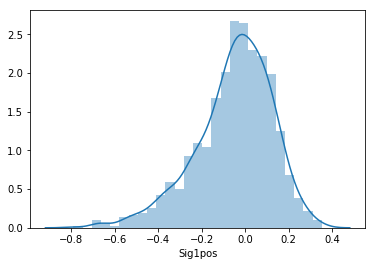

In [13]:
sns.distplot(Weight_B.iloc[0])

In [14]:
# What is the overlap between the high weight genes and gene sets A and B?
num_A = geneSetA.shape[0]
num_B = geneSetB.shape[0]

num_features_pos_neg = HW_df.shape[0]

percent_overlap = pd.DataFrame({'feature': [], 
                                'percent in A': [],
                                'percent in B': []
                               })

for i in range(num_features_pos_neg):
#for i in range(2):
    row = HW_df.iloc[i]
    percent_in_A = (row.isin(geneSetA_ls).sum()/num_A)*100
    percent_in_B = (row.isin(geneSetB_ls).sum()/num_B)*100
    
    add = pd.DataFrame({'feature': [HW_df.index[i]],
                        'percent in A': [percent_in_A],
                        'percent in B': [percent_in_B]
                       })
    percent_overlap = percent_overlap.append(add)

percent_overlap

,feature,percent in A,percent in B
0,Sig0pos,0.0,0.4
0,Sig0neg,0.0,17.1
0,Sig1pos,0.0,1.5
0,Sig1neg,0.0,19.2
0,Sig2pos,0.0,0.3
0,Sig2neg,53.0,17.3
0,Sig3pos,0.0,0.8
0,Sig3neg,0.0,17.8
0,Sig4pos,0.0,0.9
0,Sig4neg,0.0,15.6


In [15]:
# Are there any features that are nonzero?
overlap_in_A = percent_overlap.iloc[percent_overlap["percent in A"].nonzero()[0]]
overlap_in_B = percent_overlap.iloc[percent_overlap["percent in B"].nonzero()[0]]

print(overlap_in_A.shape)
print(overlap_in_B.shape)
overlap_in_A

(18, 3)
(596, 3)


,feature,percent in A,percent in B
0,Sig2neg,53.0,17.3
0,Sig19neg,95.0,20.7
0,Sig23neg,9.0,20.4
0,Sig47neg,42.0,5.7
0,Sig64neg,4.0,15.0
0,Sig77pos,100.0,0.6
0,Sig90neg,13.0,5.7
0,Sig106pos,79.0,0.3
0,Sig141pos,90.0,0.4
0,Sig173neg,100.0,14.4


In [16]:
overlap_in_B

,feature,percent in A,percent in B
0,Sig0pos,0.0,0.4
0,Sig0neg,0.0,17.1
0,Sig1pos,0.0,1.5
0,Sig1neg,0.0,19.2
0,Sig2pos,0.0,0.3
0,Sig2neg,53.0,17.3
0,Sig3pos,0.0,0.8
0,Sig3neg,0.0,17.8
0,Sig4pos,0.0,0.9
0,Sig4neg,0.0,15.6
